# Parallel Hybrid Model

Weighted Estimater By Leo Lee

In [ ]:
from surprise import AlgoBase

class HybridModel(AlgoBase):

    def __init__(self, models, weights, sim_options={}):
        AlgoBase.__init__(self)
        self.models = models
        self.weights = weights

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        for model in self.models:
            model.fit(trainset)

        return self

    def estimate(self, user_id, item_id):

        scores_sum = 0
        weights_sum = 0

        for i in range(len(self.models)):
            scores_sum += self.models[i].estimate(user_id, item_id) * self.weights[i] # 3*1/4+4*3/4 laga ra
            weights_sum += self.weights[i] # always becomes one

        return scores_sum / weights_sum

## Setup

In [1]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162998 sha256=92082704985c0b142ef48f778b497576f0f5828bf461963726b07a13e5723193
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
!pip show scikit-surprise

Name: scikit-surprise
Version: 1.1.3
Summary: An easy-to-use library for recommender systems.
Home-page: https://surpriselib.com
Author: Nicolas Hug
Author-email: contact@nicolas-hug.com
License: GPLv3+
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy
Required-by: surprise


In [ ]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
!python -m pip uninstall sentence-transformers --yes
!python -m pip uninstall transformers --yes
!python -m pip install -U sentence-transformers

Found existing installation: transformers 4.38.2
Uninstalling transformers-4.38.2:
  Successfully uninstalled transformers-4.38.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 50.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2


Import Library

In [3]:
import pandas as pd
from surprise import Reader, Dataset, KNNBasic, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

## Data Preprocessing

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [5]:
from surprise import Dataset

# Load the movielens-100k dataset
data_rate = pd.read_csv('/content/ratings.csv', delimiter=",", names=["userId", "bookId", "rating", "timestamp"])
data_rate = data_rate.drop(columns='timestamp')
data_rate = data_rate[['userId', 'bookId', 'rating']]
print(data_rate)

       userId    bookId  rating
0           1      1384     4.0
1           1      1376     4.0
2           1     30119     3.0
3           1  24769928     5.0
4           1     30119     4.0
...       ...       ...     ...
60136     610      1420     3.5
60137     610     15997     5.0
60138     610      1420     4.0
60139     610    250048     4.0
60140     610    138372     3.0

[60141 rows x 3 columns]


modify the ID from 1 to n

In [ ]:
import pandas as pd

# Create a new column 'sequential_id' and assign sequential numeric IDs
data['user_id'] = range(1, len(data) + 1)

# Save the modified DataFrame back to a new CSV file
data.to_csv('/content/sample_data/interactions_small_modify.csv', index=False)

TypeError: object of type 'DatasetAutoFolds' has no len()

Data Wrangling

In [6]:
# Filter ratings that are out of range
data_rate = data_rate[data_rate['rating']!=0]

In [7]:
# Prepare data for surprise: build a Suprise reader object
reader = Reader(rating_scale=(1, 5))

Load the data to surprise

In [8]:
from surprise import Dataset
from surprise import Reader

import os


# Load `data_rate` into a Surprise Dataset
data = Dataset.load_from_df(data_rate, reader)

In [9]:
# Retrieve the trainset (whole dataset)
#train_set, test_set = train_test_split(data, test_size=.90)

trainset = data.build_full_trainset()
print('number of users: %d' % trainset.n_users)
print('number of items: %d' % trainset.n_items)
print('number of ratings: %d' % trainset.n_ratings)

number of users: 485
number of items: 12293
number of ratings: 60141


# Test Base Models

## user-based

In [10]:
from surprise import Dataset
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate

eval_cv = 5
user_based_algo = KNNWithMeans(k=20, sim_options={
  "name": "cosine",
  "user_based": True,  # Compute  similarities between users
})

user_based_r = cross_validate(user_based_algo, data, measures=['rmse'], cv=eval_cv,verbose=True)
user_based_r_1 = user_based_r['test_rmse'].mean()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0445  1.0238  1.0336  1.0408  1.0212  1.0328  0.0091  
Fit time          0.27    0.33    0.30    0.46    0.35    0.34    0.07    
Test time         1.54    1.72    1.69    2.89    1.74    1.92    0.49    


## item-based

In [11]:
from surprise import Dataset
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate

eval_cv = 5
item_based_algo = KNNWithMeans(k=20, sim_options={
  "name": "cosine",
  "user_based": False,  # Compute  similarities between users
})

item_based_r = cross_validate(user_based_algo, data, measures=['rmse'], cv=eval_cv,verbose=True)
item_based_r_1 = user_based_r['test_rmse'].mean()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0395  1.0213  1.0285  1.0428  1.0219  1.0308  0.0089  
Fit time          0.30    0.27    0.31    0.32    0.45    0.33    0.06    
Test time         1.76    1.66    1.75    2.12    2.40    1.94    0.28    


## SVD

In [12]:
import timeit
from surprise import SVD
from surprise import SVDpp
from surprise import BaselineOnly
from surprise import Dataset
from surprise.model_selection import cross_validate
import os
from surprise import Reader

n_factors = 10
n_epochs = 30

In [17]:
method = 'SVD'

start = timeit.default_timer()
algo = SVD(n_factors=n_factors, n_epochs=n_epochs, biased=True)
results= cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
stop = timeit.default_timer()
run_time = stop - start
print('Run Time: ', run_time)
SVD_result = results['test_rmse'].mean()
SVD_result_1 = results['test_rmse']

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9717  0.9537  0.9558  0.9696  0.9590  0.9620  0.0073  
Fit time          0.98    0.90    0.91    0.90    0.91    0.92    0.03    
Test time         0.08    0.08    0.07    0.07    0.07    0.07    0.00    
Run Time:  6.180738651999945


## NCF

In [20]:
from models import NCF

hyperparameters = {
    'MLP_layers': [20, 10],
    'learning_rate': 0.01
}

eval_cv = 5

# use the NCF algorithm
algo_NCF = NCF(**hyperparameters)

results = cross_validate(algo_NCF, data, measures=['rmse'], cv=eval_cv,verbose=True)


NCF_result = results['test_rmse'].mean()
NCF_result_1 = results['test_rmse']

Pretraining GMF...
Epoch 1/5
3007/3007 [==============================] - 10s 3ms/step - loss: 1.1914
Epoch 2/5
3007/3007 [==============================] - 10s 3ms/step - loss: 1.0910
Epoch 3/5
3007/3007 [==============================] - 8s 3ms/step - loss: 1.0913
Epoch 4/5
3007/3007 [==============================] - 11s 4ms/step - loss: 1.0912
Epoch 5/5
3007/3007 [==============================] - 9s 3ms/step - loss: 1.0910
Pretraining MLP...
Epoch 1/20
3007/3007 [==============================] - 10s 3ms/step - loss: 1.0685
Epoch 2/20
3007/3007 [==============================] - 10s 3ms/step - loss: 0.9128
Epoch 3/20
3007/3007 [==============================] - 9s 3ms/step - loss: 0.8946
Epoch 4/20
3007/3007 [==============================] - 10s 3ms/step - loss: 0.8887
Epoch 5/20
3007/3007 [==============================] - 10s 3ms/step - loss: 0.8849
Epoch 6/20
3007/3007 [==============================] - 8s 3ms/step - loss: 0.8805
Epoch 7/20
3007/3007 [=========================

Plot to the Graph

In [21]:
import pandas as pd
# table
result_lict_Q3 = [
    {'method': 'SVD', 'rmse': SVD_result},
    {'method': 'userb_kNN', 'rmse': user_based_r_1},
    {'method': 'itemb_kNN', 'rmse': item_based_r_1},
    {'method': 'NCF', 'rmse': NCF_result},
]

result_df_Q3 = pd.DataFrame.from_dict(result_lict_Q3)

result_df_Q3

,method,rmse
0,SVD,0.961957
1,userb_kNN,1.032770
2,itemb_kNN,1.032770
3,NCF,1.026815


(0.6, 1.2)

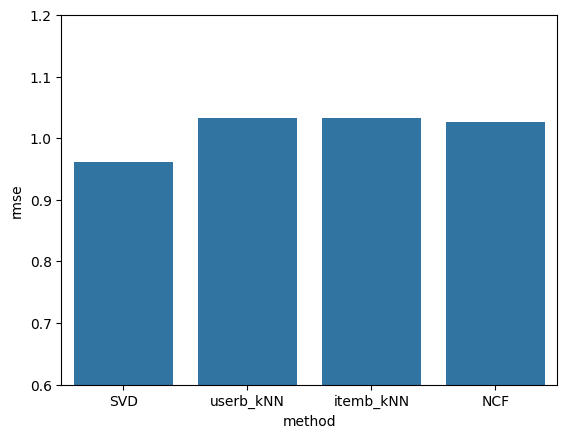

In [22]:
# figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
sns.barplot(x="method", y="rmse", data=result_df_Q3)
ax.set_ylim(0.6, 1.2)

ttest for best result

In [25]:
from scipy.stats import ttest_ind

ttest_ind(NCF_result_1, SVD_result_1) # need modify to best two

TtestResult(statistic=7.986379623707242, pvalue=4.420710446863538e-05, df=8.0)

## content_based_recommendation

1.Loading data

In [ ]:
bookings_data = '/content/drive/MyDrive/data_stored/books_metadata_large.csv'
ratings_data = '/content/drive/MyDrive/data_stored/interactions_small_modify.csv'
bookings_df = pd.read_csv(bookings_data)
ratings_df = data_rate

In [ ]:
ratings_df

,user_id,book_id,is_read,rating
0,1,1384,True,4
1,2,1376,True,4
2,3,30119,True,5
4,5,30119,True,3
5,6,240007,True,4
...,...,...,...,...
19978,19979,1519,True,4
19982,19983,19016323,True,2
19983,19984,1595454,True,5
19994,19995,23919,True,4


In [ ]:
# Let's check for missing values
ratings_df.isna().sum()

user_id    0
book_id    0
is_read    0
rating     0
dtype: int64

In [ ]:
print('bookings_df Shape:',bookings_df.shape)
bookings_df

bookings_df Shape: (36514, 29)


,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,NaN,1,[],US,eng,"[{'count': '8', 'name': 'to-read'}, {'count': ...",NaN,False,3.83,NaN,...,11.0,NaN,1887.0,https://www.goodreads.com/book/show/16037549-v...,https://images.gr-assets.com/books/1348176637m...,16037549,3,5212748,Vision of Sir Launfal and Other Poems,Vision of Sir Launfal and Other Poems
1,0811223981,2,[],US,NaN,"[{'count': '100', 'name': 'to-read'}, {'count'...",NaN,False,3.83,B00U2WY9U8,...,4.0,NaN,2015.0,https://www.goodreads.com/book/show/22466716-f...,https://images.gr-assets.com/books/1404958407m...,22466716,37,41905435,Fairy Tales: Dramolettes,Fairy Tales: Dramolettes
2,0374428115,7,[],US,NaN,"[{'count': '32', 'name': 'to-read'}, {'count':...",NaN,False,4.38,NaN,...,7.0,NaN,2008.0,https://www.goodreads.com/book/show/926662.Gro...,https://s.gr-assets.com/assets/nophoto/book/11...,926662,45,911665,Growltiger's Last Stand and Other Poems,Growltiger's Last Stand and Other Poems
3,0156182890,12,[],US,NaN,"[{'count': '554', 'name': 'to-read'}, {'count'...",NaN,False,3.71,B00IWTRB1W,...,3.0,NaN,1964.0,https://www.goodreads.com/book/show/926667.The...,https://images.gr-assets.com/books/1382939971m...,926667,115,995066,The Cocktail Party,The Cocktail Party
4,1942004192,4,[],US,eng,"[{'count': '228', 'name': 'to-read'}, {'count'...",NaN,False,5.00,NaN,...,12.0,First,2015.0,https://www.goodreads.com/book/show/29065952-l...,https://images.gr-assets.com/books/1455198396m...,29065952,9,49294781,Louder Than Everything You Love,Louder Than Everything You Love
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36509,NaN,1,[],US,eng,"[{'count': '2', 'name': 'poetry'}, {'count': '...",B004CYF8NY,True,5.00,NaN,...,NaN,NaN,NaN,https://www.goodreads.com/book/show/9874488-ta...,https://s.gr-assets.com/assets/nophoto/book/11...,9874488,1,14766173,Take Out from the Writer's Café,Take Out from the Writer's Café
36510,NaN,1,['714239'],US,NaN,"[{'count': '1158', 'name': 'to-read'}, {'count...",B002LIT2S0,True,3.65,B004UK2JO6,...,NaN,NaN,NaN,https://www.goodreads.com/book/show/7657489-a-...,https://s.gr-assets.com/assets/nophoto/book/11...,7657489,3,854054,A Book of Nonsense,A Book of Nonsense
36511,0879230789,1,[],US,NaN,"[{'count': '3', 'name': 'poetry'}]",NaN,False,3.50,NaN,...,NaN,NaN,NaN,https://www.goodreads.com/book/show/3762261-su...,https://s.gr-assets.com/assets/nophoto/book/11...,3762261,2,3806167,Sunbelly (Number 2 in the First Godine Poetry ...,Sunbelly (Number 2 in the First Godine Poetry ...
36512,NaN,4,[],US,spa,"[{'count': '247044', 'name': 'to-read'}, {'cou...",NaN,False,3.73,B008H3RGCW,...,NaN,NaN,2013.0,https://www.goodreads.com/book/show/23452091-o...,https://images.gr-assets.com/books/1414353152m...,23452091,55,3356006,Odisea,Odisea


In [ ]:
bookings_df.isna().sum()

isbn                     9980
text_reviews_count          0
series                      0
country_code                0
language_code           19462
popular_shelves             0
asin                    34644
is_ebook                    0
average_rating              0
kindle_asin             26879
similar_books               0
description              7526
format                   7025
link                        0
authors                     0
publisher                6033
num_pages                7505
publication_day         14956
isbn13                   8155
publication_month       13020
edition_information     33089
publication_year         5816
url                         0
image_url                   0
book_id                     0
ratings_count               0
work_id                     0
title                       2
title_without_series        2
dtype: int64

In [ ]:
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)
    #print(type(s))
    #return "".join([char for char in s if char not in string.punctuation])

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [ ]:
#processing the movie overview
bookings_df['description'] = bookings_df['description'].fillna('')
bookings_df['cleaned'] = bookings_df['description'].apply(_removeNonAscii)
# bookings_df['cleaned'] = bookings_df.cleaned.apply(func = remove_html)
bookings_df['cleaned']

0        Number 30 in a series of literary pamphlets pu...
1        Fairy Tales gathers the unconventional verse d...
2        Three poems describe the nighttime adventures ...
3        A modern verse play about the search for meani...
4        Louder Than Everything You Love is about trans...
                               ...                        
36509    Appetizers\n*Poetry- Acrostic\nWo(Man)- Diaman...
36510    There was an Old Derry down Derry, who loved t...
36511                                                     
36512    'Muse, tell me of a man: a man of much resourc...
36513    Gathers poems by William Blake, Emily Bronte, ...
Name: cleaned, Length: 36514, dtype: object

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
# It will take a few minutes to download the pre-trained model at first time,you can try different models in https://www.sbert.net/docs/pretrained_models.html
from sentence_transformers import SentenceTransformer
#sentences = ["This is an example sentence", "Each sentence is converted"]

sentences = bookings_df['cleaned'].values
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
sentence_embeddings = model.encode(sentences)
sentence_embeddings[0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

KeyboardInterrupt: 

Use user id = 10 as a new user to give rating and build a user profile for it

In [ ]:
user_rating_df = ratings_df[ratings_df['userId'] == 10]
user_preference_df = user_rating_df.sample(frac=0.20, random_state=2)
user_preference_df = user_preference_df.reset_index(drop=True)
user_preference_df

In [ ]:
book_we_vector = pd.DataFrame(np.vstack(sentence_embeddings))
we_feature_list = book_we_vector.columns.values
book_we_vector

In [ ]:
book_we_vector['book_id'] = book_we_vector['book_id']


user_book_rating_df = pd.merge(user_preference_df, book_we_vector)
user_book_rating_df

In [ ]:
# Maintain the Word-embeddings information
user_book_df = user_book_rating_df.copy(deep=True)
user_book_df = user_book_df[we_feature_list]
user_book_df

In [ ]:
rating_weight = [1/len(user_preference_df)]*len(user_preference_df)
user_profile = user_book_df.T.dot(rating_weight)
user_profile

the result of the recommendation based on the user 10 profile to calculate the similarity

In [ ]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Compute the cosine similarity

u_v = user_profile.values
u_v_matrix =  [u_v]

recommendation_table =  cosine_similarity(u_v_matrix, sentence_embeddings)
recommendation_table_df = bookings_df[['book_id', 'title']].copy(deep=True)
recommendation_table_df['similarity'] = recommendation_table[0]
recommendation_table_df

rec_result_plot_based_case_2 = recommendation_table_df.sort_values(by=['similarity'], ascending=False)
rec_result_plot_based_case_2.head(10)